<a href="https://colab.research.google.com/github/iamviji/project/blob/master/MainModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf project
!git clone https://github.com/iamviji/project.git
!ls
!ls project
!pip install pyldpc
!pip install scikit-commpy



Cloning into 'project'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 41 (delta 8), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (41/41), done.
project  sample_data
MainModel.ipynb  README.md  util.py
     |████████████████████████████████| 1.1MB 4.4MB/s 
  Created wheel for pyldpc: filename=pyldpc-0.7.9-cp36-none-any.whl size=14306 sha256=89972fec0cd42064d9b1778eeb267c9d354a51cbe77d71f14d8a0b0c36f17492
  Stored in directory: /root/.cache/pip/wheels/47/7a/10/e94058ba8b0b6d98bf2719226d18d3dd6056525ad7b984c068
Successfully built pyldpc
     |████████████████████████████████| 51kB 1.7MB/s 


In [2]:
import pyldpc
import commpy
import numpy 
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 3
num_bits_in_parity_check = 6 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [4]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

init = tf.global_variables_initializer ()
sess = tf.Session ()
sess.run(init)

def AWGNChannelOutput (xx, snr , s):
  sigma = Snr2Sigma (snr)
  awgn_channel_output_message = s.run ([awgn_channel_output], feed_dict={noise_std_dev:sigma, channel_input:xx})
  return awgn_channel_output_message

In [5]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 11 channel_size= 18
input_message_size= 11 channel_size= 18
[[0 0 1 ... 1 0 1]
 [1 0 0 ... 0 1 1]
 [0 1 1 ... 1 0 0]
 ...
 [1 0 0 ... 0 0 1]
 [1 1 1 ... 0 1 1]
 [0 0 0 ... 0 0 0]]


This section tries to compare BER and Time performance of PYLDPC in following 3 cases
1. SNR Noise function provided in encoder function of pyldpc library (pyldpc.encode)
2. SNR Noise function provided by commpy library (commpy.channels.awgn) 
3. SNR Noise function implemented using tensorflow 

In [6]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_tensor  = numpy.array(())
times_per_iter_tensor = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    sigma = Snr2Sigma (snr)
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})[0]
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      #print ("count=",abs(decoded_message-input_message[i]).sum())
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_tensor=numpy.append(ber_per_iter_tensor ,ber)
  times_per_iter_tensor=numpy.append(times_per_iter_tensor, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.85s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.62s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 5.39s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 7.25s
SNR: 0.000:
 -> BER: 0.58
 -> Total Time: 18.10s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.41s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.85s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.46s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 6.47s
SNR: 0.500:
 -> BER: 0.50
 -> Total Time: 15.19s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.49s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.93s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 4.55s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 6.14s
SNR: 1.000:
 -> BER: 0.43
 -> Total Time: 15.12s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 1.46s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 2.46s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [7]:
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_awgn  = numpy.array(())
times_per_iter_awgn = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    awgn_channel_output_message = commpy.channels.awgn(encoded_message, snr)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_awgn=numpy.append(ber_per_iter_awgn ,ber)
  times_per_iter_awgn=numpy.append(times_per_iter_awgn, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.53s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.26s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.67s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.35s
SNR: 0.000:
 -> BER: 0.60
 -> Total Time: 15.82s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.33s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.61s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.89s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.35s
SNR: 0.500:
 -> BER: 0.50
 -> Total Time: 13.19s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.04s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.13s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.24s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.27s
SNR: 1.000:
 -> BER: 0.43
 -> Total Time: 10.69s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.84s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.70s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [8]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_pyldpc=numpy.append(ber_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.63s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.67s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 6.15s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 8.29s
SNR: 0.000:
 -> BER: 0.60
 -> Total Time: 19.75s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.53s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.84s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.14s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.46s
SNR: 0.500:
 -> BER: 0.53
 -> Total Time: 13.97s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.98s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.06s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.09s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.35s
SNR: 1.000:
 -> BER: 0.44
 -> Total Time: 10.49s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.83s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.66s
SNR: 1.500 - Iter: 750 - Last 250.0 it

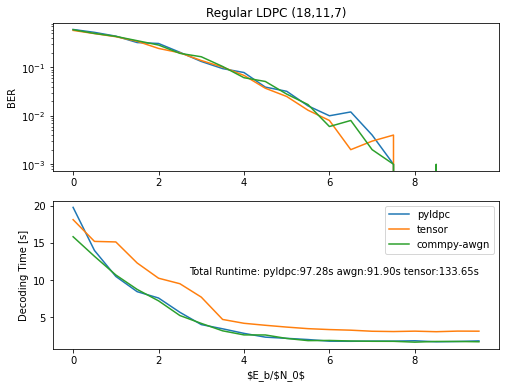

In [10]:
# Compare 3 AWGN(Tensorflow, CommPy, PYLDPC) Simulation on LDPC
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="tensor") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_awgn,'', label="commpy-awgn") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

<B>Conclussion:</B>
      It proved that tensorflow behaves similar to AWGN noise channel provided by pyldpc, commpy. But tensor flow based one takes adds little more time delay. This need to be offseted if we are comparing performance. 

In [11]:
# Define Model 

# input_message_length is initialized by ldpc encoder
num_hidden_1 = CHANEL_SIZE
print ("input_message_length=", input_message_length)

input_message_x = tf.placeholder("float32", [None, input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, CHANEL_SIZE], name="input_channel_x")

weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([input_message_length, num_hidden_1], -1, 1), name="encoder_l1_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1, input_message_length], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length, input_message_length], -1, 1), name="decoder_l2_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="encoder_l1_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l2_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  #layer_2 = tf.round(layer_1)
  layer_2 =  layer_1 / tf.sqrt(tf.reduce_mean(tf.square(layer_1)))
  return layer_2

def dl_decoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  layer_2 = tf.nn.sigmoid (tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  return layer_2

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_decoder_output = dl_decoder (dl_decoder_input)
dl_decoder_only_output = dl_decoder(input_channel_x)


loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) ))
lr = tf.placeholder(dtype=tf.float32,shape=[])
rms_optimizer = tf.train.AdamOptimizer(learning_rate=0.0005).minimize (loss1)

input_message_length= 11


In [12]:
batch_size = 500
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))

# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 40
display_step = epochs/2
num_of_batches = len(training_input_message) / batch_size
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = 0.1

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  sigma = 1.0*Snr2Sigma (snr)
  print ("Training for SNR=", snr, " sigma=", sigma) 
  for e in range(epochs):
    for j in range (int(num_of_batches)):
      x_train_batch = training_input_message [j*batch_size:(j+1)*batch_size]
      x_train_batch_float = x_train_batch.astype("float32")
      _, l = train_sess.run ([rms_optimizer, loss1], feed_dict={input_message_x:x_train_batch_float, awgn_noise_std_dev_x:sigma, lr:lrate})
      if (l < 0.5): lrate = 0.001
      if (l < 0.25): lrate = 0.0001
      if j % display_step == 0:
        print('Step %i: Minibatch Loss: %f' % (i*display_step+j, l))

[[0 1 1 ... 0 0 0]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [1 1 0 ... 1 0 1]
 [0 1 0 ... 0 0 1]
 [1 1 0 ... 1 0 1]]
10000
batch_size: 500 num_of_batcches: 20.0
Training for SNR= 0.0  sigma= 1.0
Step 19980: Minibatch Loss: 1.078155
Step 19980: Minibatch Loss: 1.053741
Step 19980: Minibatch Loss: 1.017306
Step 19980: Minibatch Loss: 0.993859
Step 19980: Minibatch Loss: 0.959425
Step 19980: Minibatch Loss: 0.956119
Step 19980: Minibatch Loss: 0.925142
Step 19980: Minibatch Loss: 0.889707
Step 19980: Minibatch Loss: 0.870241
Step 19980: Minibatch Loss: 0.855791
Step 19980: Minibatch Loss: 0.839393
Step 19980: Minibatch Loss: 0.806295
Step 19980: Minibatch Loss: 0.801872
Step 19980: Minibatch Loss: 0.798618
Step 19980: Minibatch Loss: 0.783268
Step 19980: Minibatch Loss: 0.772613
Step 19980: Minibatch Loss: 0.763285
Step 19980: Minibatch Loss: 0.749976
Step 19980: Minibatch Loss: 0.737277
Step 19980: Minibatch Loss: 0.726697
Step 19980: Minibatch Loss: 0.714457
Step 19980: Minibatch Los

In [13]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #print (encoded_message[0][0])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.38s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.72s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 1.04s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.36s
SNR: 0.000:
 -> BER: 0.73
 -> Total Time: 3.51s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.37s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.70s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 1.05s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.38s
SNR: 0.500:
 -> BER: 0.70
 -> Total Time: 3.51s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.32s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.65s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.96s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.30s
SNR: 1.000:
 -> BER: 0.66
 -> Total Time: 3.23s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.35s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.70s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

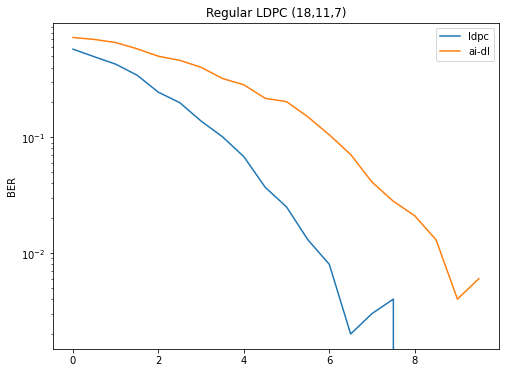

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()